In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('../data/credit_card_default_train.csv', index_col = 'Client_ID')

In [3]:
df.head()

Balance_Limit_V1 Gender EDUCATION_STATUS MARITAL_STATUS  \
Client_ID                                                           
A2                      1M      M         Graduate          Other   
A3                      1M      F      High School          Other   
A4                    100K      F      High School         Single   
A5                    200K      F         Graduate         Single   
A6                      1M      F         Graduate          Other   

                    AGE  PAY_JULY  PAY_AUG  PAY_SEP  PAY_OCT  PAY_NOV  ...  \
Client_ID                                                              ...   
A2                31-45        -1       -1       -1       -1       -1  ...   
A3         Less than 30         0       -1       -1       -1       -1  ...   
A4                31-45         4        3        2        2       -2  ...   
A5                31-45         2        0        0        0        0  ...   
A6                31-45         2        2        0        0        0  ...   

           DUE_AMT_OCT  DUE_AMT_NOV  DUE_AMT_DEC  PAID_AMT_JULY  PAID_AMT_AUG  \
Client_ID                                                                       
A2               39418       162772       -13982           3437          6004   
A3               43530        80811       124590         151818         46200   
A4                   0            0            0              0             0   
A5               97309       100353       102740           3855          3890   
A6              435354       445271       453899              0         20790   

           PAID_AMT_SEP  PAID_AMT_OCT  PAID_AMT_NOV  PAID_AMT_DEC  \
Client_ID                                                           
A2                39418        162772             0        538165   
A3                43530         80811           942         33666   
A4                    0             0             0             0   
A5                 3696          4620          4049          3918   
A6                16170         17325         16401         17325   

           NEXT_MONTH_DEFAULT  
Client_ID                      
A2                          0  
A3                          0  
A4                          1  
A5                          1  
A6                          0  

[5 rows x 24 columns]

In [4]:
df.NEXT_MONTH_DEFAULT.value_counts()

0    18670
1     5330
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [5]:
df['balance_limit_multiplier'] = df.Balance_Limit_V1.str[-1].replace({'K':1000, 'M':1000000})
df['balance_limit'] = df.Balance_Limit_V1.str[:-1].astype(float) * df['balance_limit_multiplier']
df['balance_limit'] = df.balance_limit.astype(int)
df.drop(['Balance_Limit_V1', 'balance_limit_multiplier'], inplace=True, axis=1)

# AGE

([<matplotlib.axis.XTick at 0x7f1976342b70>,
 <a list of 4 Text xticklabel objects>)

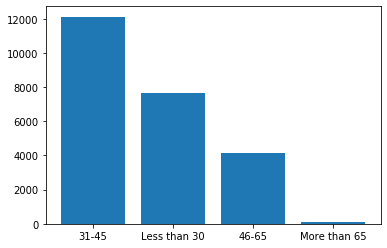

In [6]:
age_values = df.AGE.value_counts()
pos = list(range(age_values.shape[0]))
plt.bar(pos, height=age_values.values)
plt.xticks(pos, age_values.index)

([<matplotlib.axis.XTick at 0x7f1976331198>,
 <a list of 4 Text xticklabel objects>)

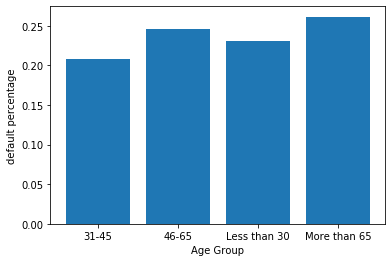

In [7]:
default_perc = df.groupby('AGE').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Age Group')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

# Gender

In [8]:
gender_values = df.Gender.value_counts()
pos = list(range(gender_values.shape[0]))
plt.bar(pos, height=gender_values.values)
plt.xticks(pos, gender_values.index)

([<matplotlib.axis.XTick at 0x7f19762a1e80>,
 <a list of 2 Text xticklabel objects>)

([<matplotlib.axis.XTick at 0x7f1976329f98>,
 <a list of 2 Text xticklabel objects>)

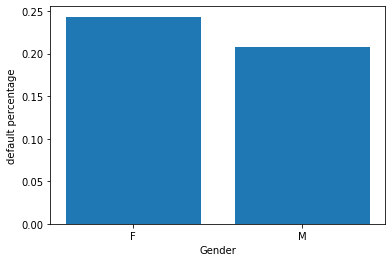

In [9]:
default_perc = df.groupby('Gender').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Gender')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

# Education Status

([<matplotlib.axis.XTick at 0x7f19761da320>,
 <a list of 3 Text xticklabel objects>)

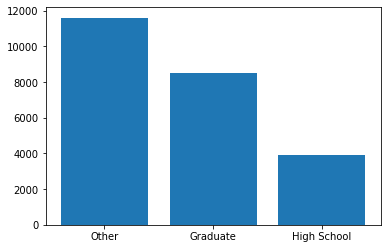

In [10]:
education_values = df.EDUCATION_STATUS.value_counts()
pos = list(range(education_values.shape[0]))
plt.bar(pos, height=education_values.values)
plt.xticks(pos, education_values.index)

([<matplotlib.axis.XTick at 0x7f19761b74e0>,
 <a list of 3 Text xticklabel objects>)

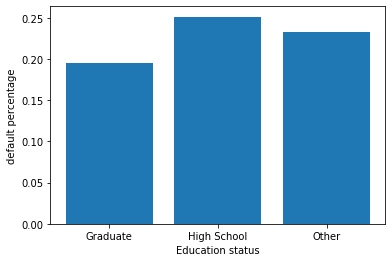

In [11]:
default_perc = df.groupby('EDUCATION_STATUS').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Education status')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

# Marital Status

([<matplotlib.axis.XTick at 0x7f1976104b38>,
 <a list of 2 Text xticklabel objects>)

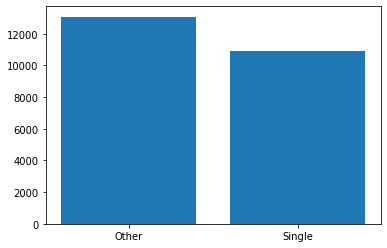

In [12]:
marital_values = df.MARITAL_STATUS.value_counts()
pos = list(range(marital_values.shape[0]))
plt.bar(pos, height=marital_values.values)
plt.xticks(pos, marital_values.index)

([<matplotlib.axis.XTick at 0x7f19760e37f0>,
 <a list of 2 Text xticklabel objects>)

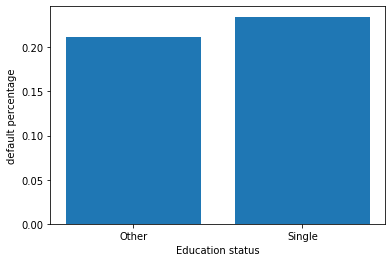

In [13]:
default_perc = df.groupby('MARITAL_STATUS').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Education status')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

In [14]:
month_list = ['JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
pay_cols = ['PAY_' + m for m in month_list]
paid_cols = ['PAID_AMT_' + m for m in month_list]
due_cols = ['DUE_AMT_' + m for m in month_list]

# Feature Engineering

In [15]:
df['default_count'] = (df[pay_cols] > 0).sum(axis=1)
df['not_default_count'] = (df[pay_cols] <= 0).sum(axis=1)
df['payment_delay_sum'] = df[pay_cols].clip(0).sum(axis=1)
df['payment_advance_sum'] = df[pay_cols].clip(upper=0).sum(axis=1)*-1

In [16]:
# for m in range(1,6):
#     df['pending_amount_'+month_list[m]] = df['DUE_AMT_'+month_list[m]] - df['PAID_AMT_'+month_list[m-1]]

# df['accumilated_balance'] = df['balance_limit'] + df['PAID_AMT_JULY']+df['PAID_AMT_AUG']+df['PAID_AMT_SEP']+df['PAID_AMT_OCT']+df['PAID_AMT_NOV']+df['PAID_AMT_DEC']\
# - (df['DUE_AMT_JULY'] + df['DUE_AMT_AUG'] + df['DUE_AMT_SEP'] + df['DUE_AMT_OCT'] + df['DUE_AMT_NOV'] + df['DUE_AMT_DEC'])

df['too_delay_count'] = (df[pay_cols] > 1).sum(axis=1)
df['pay_too_early_count'] = (df[pay_cols] <= -2).sum(axis=1)

# for m in month_list:
#     df['due_ratio_'+ m] = df['DUE_AMT_'+ m]/df['balance_limit']

In [17]:
# df['Gender & Marital'] = df['Gender'] +'-'+ df['MARITAL_STATUS']
# df['AGE & Marital'] =  df['AGE'] +'-'+ df['MARITAL_STATUS']
# df['edu & AGE'] =  df['AGE'] +'-'+ df['EDUCATION_STATUS']

In [18]:
df.head()

Gender EDUCATION_STATUS MARITAL_STATUS           AGE  PAY_JULY  \
Client_ID                                                                  
A2             M         Graduate          Other         31-45        -1   
A3             F      High School          Other  Less than 30         0   
A4             F      High School         Single         31-45         4   
A5             F         Graduate         Single         31-45         2   
A6             F         Graduate          Other         31-45         2   

           PAY_AUG  PAY_SEP  PAY_OCT  PAY_NOV  PAY_DEC  ...  PAID_AMT_NOV  \
Client_ID                                               ...                 
A2              -1       -1       -1       -1       -1  ...             0   
A3              -1       -1       -1       -1        0  ...           942   
A4               3        2        2       -2       -2  ...             0   
A5               0        0        0        0        0  ...          4049   
A6               2        0        0        0        0  ...         16401   

           PAID_AMT_DEC  NEXT_MONTH_DEFAULT  balance_limit  default_count  \
Client_ID                                                                   
A2               538165                   0        1000000              0   
A3                33666                   0        1000000              0   
A4                    0                   1         100000              4   
A5                 3918                   1         200000              1   
A6                17325                   0        1000000              2   

           not_default_count  payment_delay_sum  payment_advance_sum  \
Client_ID                                                              
A2                         6                  0                    6   
A3                         6                  0                    4   
A4                         2                 11                    4   
A5                         5                  2                    0   
A6                         4                  4                    0   

           too_delay_count  pay_too_early_count  
Client_ID                                        
A2                       0                    0  
A3                       0                    0  
A4                       4                    2  
A5                       1                    0  
A6                       2                    0  

[5 rows x 30 columns]

In [19]:
default_df = df[df.NEXT_MONTH_DEFAULT == 1]
not_default_df = df[df.NEXT_MONTH_DEFAULT == 0]

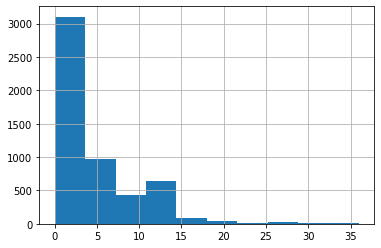

In [20]:
default_df.payment_delay_sum.hist()

In [21]:
not_default_df.payment_delay_sum.hist()

# Encode categorical

In [22]:
df.columns

Index(['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE', 'PAY_JULY',
       'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC', 'DUE_AMT_JULY',
       'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV',
       'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP',
       'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC', 'NEXT_MONTH_DEFAULT',
       'balance_limit', 'default_count', 'not_default_count',
       'payment_delay_sum', 'payment_advance_sum', 'too_delay_count',
       'pay_too_early_count'],
      dtype='object')

In [23]:
cat_cols = ['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE'] #, 'Gender & Marital', 'AGE & Marital', 'edu & AGE']

In [24]:
X = df.drop('NEXT_MONTH_DEFAULT', axis=1)
y = df['NEXT_MONTH_DEFAULT']

In [25]:
onehot = ce.OneHotEncoder(cols=cat_cols, use_cat_names=True)

In [26]:
onehot.fit(X)

OneHotEncoder(cols=['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

In [27]:
X = onehot.transform(X)

# Train test split

In [28]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Definition

## Random Forest

In [29]:
model = RandomForestClassifier(n_estimators=1900, n_jobs=-1,  max_depth=7, max_features=9, random_state=42)

## XGBoost

In [30]:
# neg_count = (train_y == 0).sum()
# pos_count = (train_y == 1).sum()
# model = XGBClassifier(n_estimators=1000, max_depth=6, 
#                       n_jobs=-1, verbose=1, learning_rate=0.01, subsample=1, colsample_bytree=1)

# Model training and evaluation

In [31]:
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
print(classification_report(test_y, pred_y))
print(f1_score(test_y, pred_y, average='micro') * 100)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3745
           1       0.72      0.37      0.49      1055

    accuracy                           0.83      4800
   macro avg       0.78      0.66      0.69      4800
weighted avg       0.82      0.83      0.81      4800

82.9375


In [32]:
confusion_matrix(test_y, pred_y)

array([[3591,  154],
       [ 665,  390]])

In [33]:
pred_train_y = model.predict(train_X)
print(classification_report(train_y, pred_train_y))
print(f1_score(train_y, pred_train_y, average='micro') * 100)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14925
           1       0.73      0.38      0.50      4275

    accuracy                           0.83     19200
   macro avg       0.79      0.67      0.70     19200
weighted avg       0.82      0.83      0.81     19200

83.05208333333334


In [34]:
print(accuracy_score(test_y, pred_y))

0.829375


In [35]:
pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

PAY_JULY                        0.252013
payment_delay_sum               0.127662
too_delay_count                 0.117220
not_default_count               0.077432
default_count                   0.072304
PAY_AUG                         0.042527
DUE_AMT_JULY                    0.028399
PAID_AMT_JULY                   0.024490
PAY_SEP                         0.021402
PAID_AMT_AUG                    0.020780
DUE_AMT_AUG                     0.018622
PAID_AMT_SEP                    0.017234
DUE_AMT_NOV                     0.015896
PAID_AMT_OCT                    0.015674
DUE_AMT_SEP                     0.015310
PAY_OCT                         0.014954
balance_limit                   0.014843
PAID_AMT_NOV                    0.014516
DUE_AMT_DEC                     0.014358
DUE_AMT_OCT                     0.013990
PAID_AMT_DEC                    0.012817
PAY_NOV                         0.011798
PAY_DEC                         0.010692
payment_advance_sum             0.005386
pay_too_early_co

# Predictions on test set

In [36]:
df_test = pd.read_csv('../data/credit_card_default_test.csv', index_col='Client_ID')

In [37]:
df_test['balance_limit_multiplier'] = df_test.Balance_Limit_V1.str[-1].replace({'K':1000, 'M':1000000})
df_test['balance_limit'] = df_test.Balance_Limit_V1.str[:-1].astype(float) * df_test['balance_limit_multiplier']
df_test['balance_limit'] = df_test.balance_limit.astype(int)
df_test.drop(['Balance_Limit_V1', 'balance_limit_multiplier'], inplace=True, axis=1)

In [38]:
df_test['default_count'] = (df_test[pay_cols] > 0).sum(axis=1)
df_test['not_default_count'] = (df_test[pay_cols] <= 0).sum(axis=1)
df_test['payment_delay_sum'] = df_test[pay_cols].clip(0).sum(axis=1)
df_test['payment_advance_sum'] = df_test[pay_cols].clip(upper=0).sum(axis=1)*-1
df_test['too_delay_count'] = (df_test[pay_cols] > 1).sum(axis=1)
df_test['pay_too_early_count'] = (df_test[pay_cols] <= -2).sum(axis=1)

In [39]:
# df_test['accumilated_balance'] = df_test['balance_limit'] + df_test['PAID_AMT_JULY']+df_test['PAID_AMT_AUG']+df_test['PAID_AMT_SEP']+df_test['PAID_AMT_OCT']+df_test['PAID_AMT_NOV']+df_test['PAID_AMT_DEC']\
# - (df_test['DUE_AMT_JULY'] + df_test['DUE_AMT_AUG'] + df_test['DUE_AMT_SEP'] + df_test['DUE_AMT_OCT'] + df_test['DUE_AMT_NOV'] + df_test['DUE_AMT_DEC'])
for m in month_list:
    df['due_ratio_'+ m] = df['DUE_AMT_'+ m]/df['balance_limit']

In [40]:
X = df_test


In [41]:
X = onehot.transform(X)

In [42]:
pred_y = model.predict(X)

In [43]:
output_df = pd.Series(pred_y, index=df_test.index).to_frame()

In [44]:
output_df.columns = ['NEXT_MONTH_DEFAULT']

In [45]:
output_df.NEXT_MONTH_DEFAULT.value_counts()

0    5340
1     660
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [46]:
output_df.head()

NEXT_MONTH_DEFAULT
Client_ID                    
A20170                      0
A16887                      0
A3430                       0
A3696                       0
A20474                      0

In [47]:
output_df.to_csv('../output/submission.csv')